In [2]:
import struct   #用来转换进制
import numpy as np
import time
# #将四字节的二进制数据转换为浮点数
# def F(data):
#     return struct.unpack("f",data)[0];
# #将四字节的二进制数据转换为长整数
# def I(data):
#     return struct.unpack("L",data)[0];
#打开文件
f = open(r'D:\2020年上机题目\data20201.dat','rb')
#'rb'表示以二进制方式打开
#读取文件描述信息
# File_Id = I(f.read(4))#读入文件标志 4表示一次读取4个字节
# File_Ver = I(f.read(4))#读入数据文件版本
# print("文件标识符：{:4X}".format(File_Id))
# 读入文件头标志部分
File_Id,File_Ver,File_Id1 = struct.unpack('<3I',f.read(12))
#id,ver,id1 = struct.unpack('<3I', f.read(12))   

In [3]:
#判断文件是否为压缩格式
if File_Ver == 514:#压缩格式版本号为0x202,转换为十进制为514
    z = 1   #1表示为压缩格式
    print("文件类型：压缩格式")
else:
    z = 0   #0表示为非压缩格式
    print("文件类型为：非压缩格式")

文件类型为：非压缩格式


In [4]:
#读取矩阵描述部分
# 读入系数矩阵结构信息
typename = {0x102:'非压缩格式',0x202:'压缩格式'}
N,Q,P = struct.unpack('<3I', f.read(12))
print('id:', hex(File_Id),'  ver:',hex(File_Ver),hex(File_Id1),"   ",typename[File_Ver])
print('阶数:', N, ' 上带宽:', Q, ' 下带宽:', P)
# N = I(f.read(4))   #读入方程组阶数
# Q = I(f.read(4))   #读入上带宽
# P = I(f.read(4))   #读入下带宽
# print("方程组阶数为：",N)
# print("方程组上带宽为：",Q)
# print("方程组下带宽为：",P)

id: 0xc0a8708   ver: 0x102 0x0     非压缩格式
阶数: 20  上带宽: 3  下带宽: 3


In [5]:
#读系数矩阵A
row = N
column = P+Q+1
if z == 1:#压缩格式
    A = np.zeros([row,column])
    for i in range(row):
        for j in range(column):
            s = f.read(4)
            A[i,j] = F(s)
elif z == 0:#非压缩格式
    A = np.zeros([row,row])
    for i in range(row):
        for j in range(row):
            s = f.read(4)
            A[i][j] = F(s)
#读取方程组等号右边的值
B = np.zeros(row)
for i in range(row):
    s = f.read(4)
    B[i] = F(s)
f.close()
            

In [6]:
#列值映射函数
def GetA(i,j):
    if z == 1:#压缩格式
        k = P+(j-i)
        #k = p+j-i+1
        if 0<=k<(P+Q+1):#限制带宽范围
            return A[i][k]
        else:
            return 0
    else:#非压缩格式
        return A[i][j]
#表示为正常的矩阵对应形式
def SetA(i,j,val):
    if z == 1:
        k = p+(j-i)
        if 0<=k<(P+Q+1):
            A[i][k] = val
    else:
        A[i][j] = val

In [7]:
#Gauss消去法
def solve():
    n = A.shape[0]  #n为方程组的行数
    x = np.zeros(n)
    for i in range(n-1):#对n-1行的方程进行消去
        for j in range(i+1,min(P+i+1,n)): #对下带宽，只针对带状区域
            I = GetA(j,i)/GetA(i,i)#系数
            for k in range(i,min(i+Q+1,n)): #对上带宽，只针对带状区域
                v = GetA(j,k) - I*GetA(i,k)
                SetA(j,k,v)
            B[j] = B[j] - B[i]*I
    x[n-1] = B[n-1]/GetA(n-1,n-1)
    for i in range(n-2,-1,-1):
        s = 0
        for j = range(i+1,min(i+1+Q,n)):
            s = s + x[j]*GetA(i,j)
        x[i] = (B[i]-s)/GetA(i,i)
        return x

SyntaxError: invalid syntax (<ipython-input-7-875c06406003>, line 15)

In [1]:
import struct
import numpy as np
import time


# 将四字节的二进制数据转换为浮点数
def F(data):
      return struct.unpack("f", data)[0];
# 将四字节的二进制数据转换为长整数
def I(data):
      return struct.unpack("L", data)[0];
#列值映射函数
def CA(i, j):
    if bz == 1:# 压缩格式
        k=P+(j-i)
        if 0<=k<(P+Q+1):# 限制带宽范围
            return A[i][k]
        else:
            return 0
    else: # 非压缩格式
        return A[i][j]

def BA(i, j, val):#表示为正常的矩阵对应形式
    if bz == 1:#当为压缩格式时
        k = P+(j-i)
        if 0<=k<(P+Q+1):
            A[i][k]=val
    else:
        A[i][j] = val 
        
def Gausssolve():#带状矩阵的高斯消去法
    n=A.shape[0]  # n为方程组的行数
    x = np.zeros(n)
    for i in range(n-1):# 对n-1行方程进行消去
        for j in range(i+1, min(P+i+1, n)):# 对下带宽，只针对带状区域
            l = CA(j, i)/CA(i, i)# 系数
            for k in range(i, min(i+Q+1, n)):# 对上带宽，只针对带状区域
                v = CA(j, k) - l*CA(i, k)
                BA(j, k, v)
            B[j] = B[j]-l*B[i]# 对右端常量进行消去
    x[n-1] = B[n-1]/CA(n-1, n-1)# 计算最后一个分量,回代过程考虑带状方程的特点
    for i in range(n-2, -1, -1):
        s = 0
        for j in range(i+1, min(i+1+Q, n)):
            s = s + x[j]*CA(i, j)
        x[i] = (B[i]-s)/CA(i, i)
    return x
time_start = time.time() #设定开始时间
f = open(r'D:\课程\计算方法(B)\计算方法作业\计算方法何国璎\data20194.dat', 'rb')
FileId  = I(f.read(4))      	   # 读入文件标志
FileVer = I(f.read(4))				# 读入数据文件版本
print("文件标识符：{:4X}".format(FileId))
if  FileVer == 514:
    bz = 1#bz压缩与非压缩文件的标志
    print("文件类型：压缩格式")
else:
    bz = 0
    print("文件类型：非压缩格式")

N = I(f.read(4))							# 读入方程组阶数
Q = I(f.read(4))							# 读入上带宽		
P = I(f.read(4))							# 读入下带宽
print("方程组的阶数", N)
print("上带宽", Q)
print("下带宽", P)

# 读取A矩阵
if bz == 1:# 压缩格式
    A = np.zeros([N, P+Q+1])
    for i in range(N):
        for j in range(P+Q+1):
            s = f.read(4)
            A[i, j] = F(s)     
        
elif bz == 0:# 非压缩格式
    A = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            s = f.read(4)
            A[i, j] = F(s)  
# 读取系数B矩阵
B = np.zeros(N)
for i in range(N):
    s = f.read(4)
    B[i] = F(s)
f.close()
time_end = time.time()
print("读取文件总用时：", round(time_end-time_start, 4), "秒")

time_start = time.time()
X = Gausssolve()
time_end = time.time()
n=len(X)
for i in range(0,n):
    X[i]=round(X[i],3)
print('方程的解为：',X)
print("解方程总用时：", round(time_end-time_start, 4), "秒")



文件标识符：F1E1D1A0
文件类型：压缩格式
方程组的阶数 52100
上带宽 8
下带宽 8
读取文件总用时： 2.2859 秒
方程的解为： [4.063 4.063 4.063 ... 4.063 4.063 4.063]
解方程总用时： 31.7972 秒


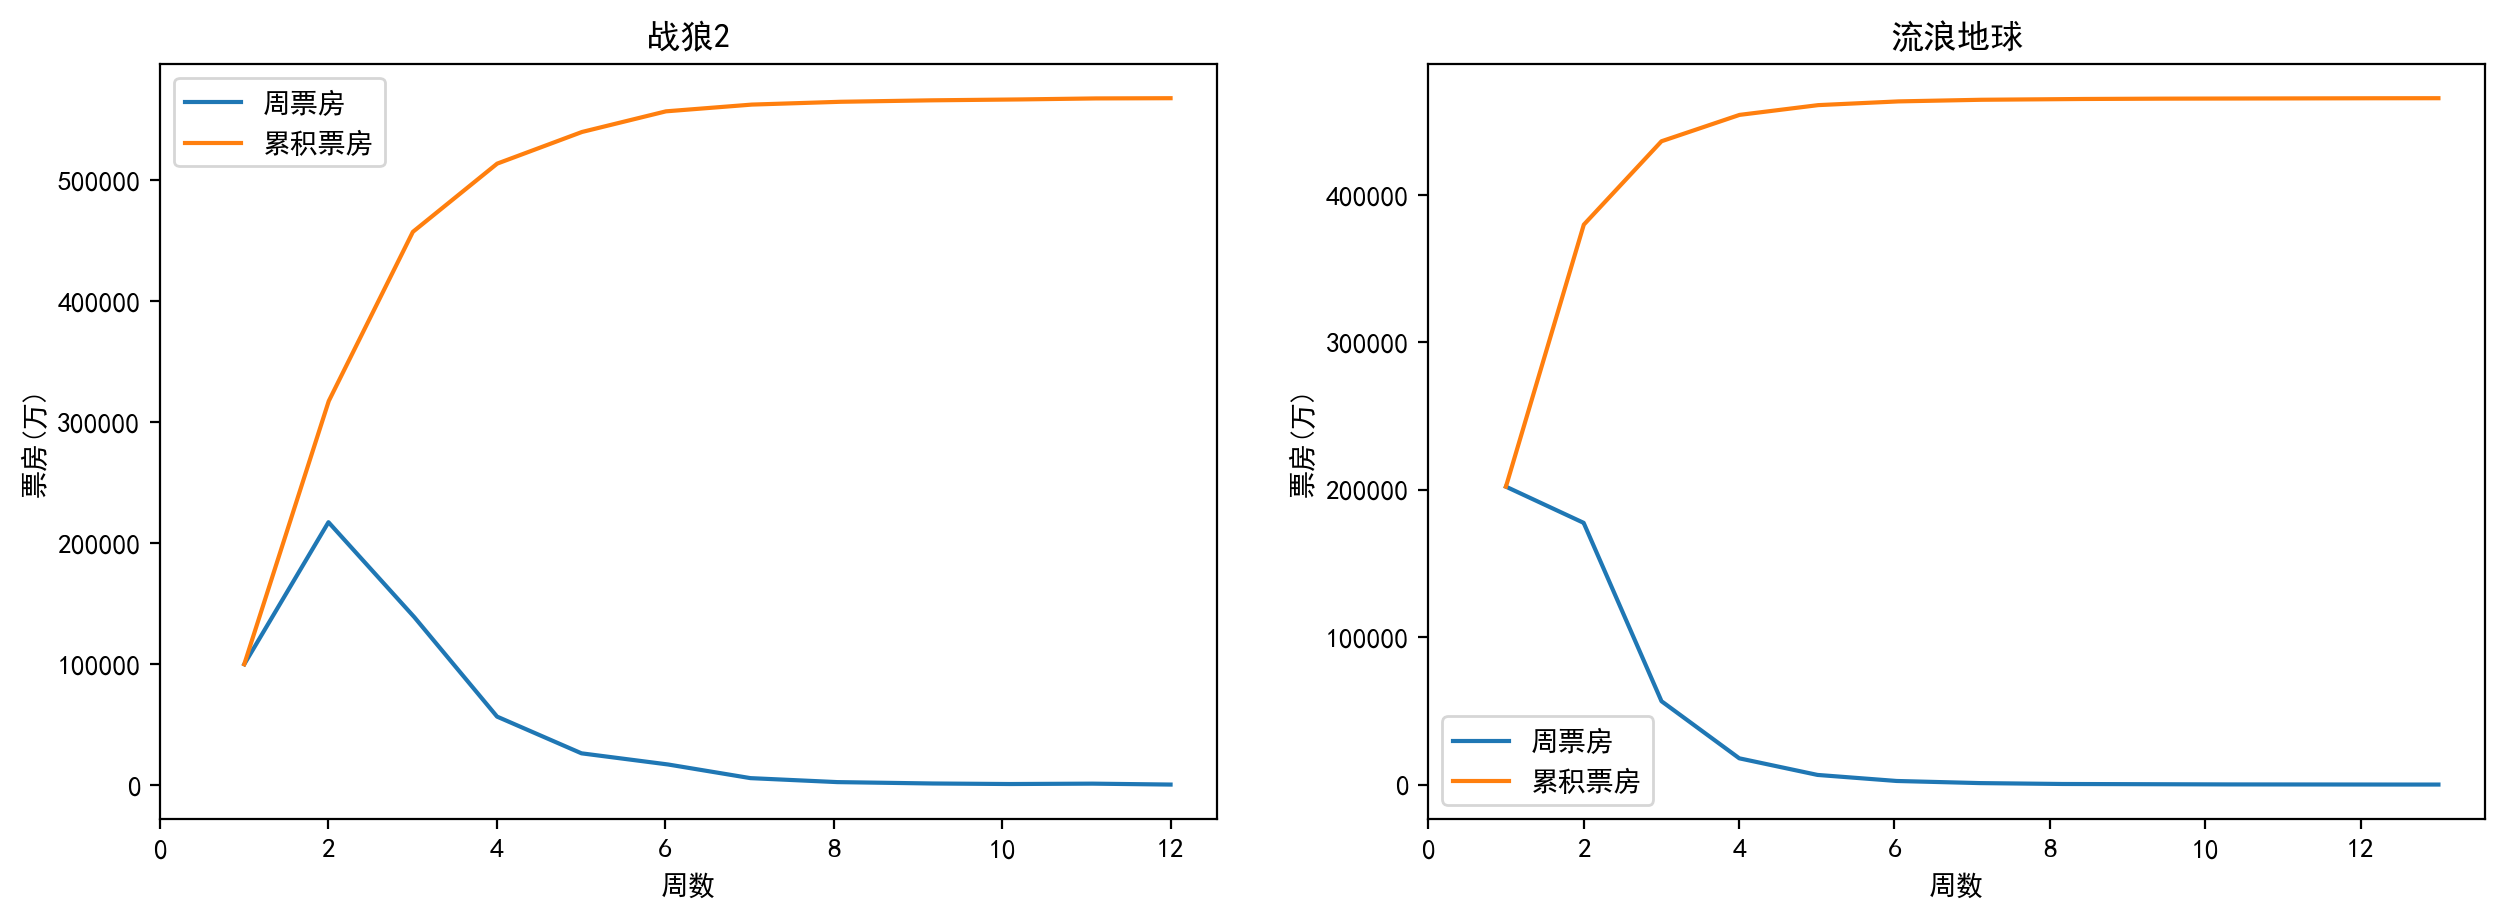

[]
第 386 周时，票房可达到50亿


In [8]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import math as mt
#找出给定点所在的区间,并求解给定点处的数值
def solve(x,y,n,X):
    n1=len(X)
    Y=[0]*n1
#较少的数据点采用全部遍历的算法
    for i in range(0,n1):
        for j in range(1,n):
            k = 1
            if(X[i]<=x[j]):
                k=j
                break
            else:
                k=j+1
        Y[i]=y[k]+((y[k]-y[k-1])/(x[k]-x[k-1]))*(X[i]-x[k])
    return Y
# 生成G矩阵。并把ｙ作为最后一列存放,m为插值多项式次数
def matrixg(x, y):
    n = len(y)
    G = np.zeros((0, n))
    print(G)
    for i in range(0, 2):
        g = np.power(x, i)
        G = np.vstack((G, g))  # 矩阵拼接生成G的转置矩阵
    y = np.array(y)  # 将y列表转换为矩阵
    G = np.vstack((G, y))
    G = np.transpose(G)  # 对矩阵进行转置,y存储在G矩阵的最后一列
    return (G)
# 最小二乘拟合
def LSS(G):
    m = G.shape[0]  # 矩阵的行数
    n = G.shape[1] - 1  # 矩阵的G矩阵除去y后的列数
    w = np.zeros(m)
# 生成Qk矩阵
    for k in range(0, n):
        s = 0
        for i in range(k, m):
            s = s + mt.pow((G[i][k]), 2)
        sgm = -np.sign(G[k][k]) * mt.sqrt(s)
        w[k] = G[k][k] - sgm
        for j in range(k + 1, m):
            w[j] = G[j][k]
        bt = sgm * w[k]
# Gk-1变换到Gk
        G[k][k] = sgm
        for j in range(k + 1, n + 1):
            t = 0
            for i in range(k, m):
                t = t + w[i] * G[i][j]
            t = t / bt
            for i in range(k, m):
                G[i][j] = G[i][j] + t * w[i]
# 解三角方程
    a = np.zeros(n)
    a[n - 1] = G[n - 1][n] / G[n - 1][n - 1]
    for i in range(n-2,-1,-1):
        s = 0
        for j in range(i+1, n):
            s = s + G[i][j] * a[j]
        a[i] = (G[i][n] - s) / G[i][i]
    return a
# 求解多项式y的值
def gsolve(x, a):
    n = len(a)
    m = x.shape[0]
    y = np.zeros(m)
    for i in range(m):
        for j in range(n):
            y[i] =y[i]+a[j] * mt.pow(x[i], j)
    return y[m-1]
#得到两部电影的票房图像进行比对

x1=np.arange(1,13,1)
yw1=[99681,217126,140241,56448,26080,17194,5564,2289,1197,619,1029,210]
ys1=[99691,316799,457025,513467,539545,556738,562302,564591,565788,566407,567437,567647]
X1=np.linspace(1,12,10000)
n1=len(x1)
Yw1=solve(x1,yw1,n1,X1)
Ys1=solve(x1,ys1,n1,X1)
x2=np.arange(1,14,1)
yw2=[202074,177540,56644,17872,6617,2514,1100,462,289,127,150,41,47]
ys2=[202117,379657,436301,454174,460791,463311,464414,464877,465167,465294,465445,465487,465534]
X2=np.linspace(1,13,10000)
n2=len(x2)
Yw2=solve(x2,yw2,n2,X2)
Ys2=solve(x2,ys2,n2,X2)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
c = plt.figure(figsize=(15,5),dpi=200)
c1=c.add_subplot(1,2,1)
plt.plot(X1,Yw1,X1,Ys1)
#plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend(['周票房', "累积票房"])
plt.title('战狼2')
plt.xlabel('周数')
plt.ylabel('票房(万)')
c2=c.add_subplot(1,2,2)
plt.plot(X2,Yw2,X2,Ys2)
#plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend(['周票房', "累积票房"])
plt.title('流浪地球')
plt.xlabel('周数')
plt.ylabel('票房(万)')
plt.show()
#对《流浪地球》票房进行预测
x=np.arange(9,14,1)
y=[465167,465294,465445,465487,465534]
G=matrixg(x,y)
a=LSS(G)
k=10
while(k):
    X = np.arange(9, k, 1)
    Y=gsolve(X,a)
    if(Y>=500000):
        break
    else:
        k=k+1
print("第",k,"周时，票房可达到50亿")
